## ✈️ Introduction

This notebook presents a machine learning solution developed for the **FlightAI Assistant** challenge. The objective is to build a model that can assist in predicting airline ticket prices using GenAI tools.

## 🎯 Problem Statement

Accurate prediction of flight ticket prices is a complex task due to the dynamic nature of the aviation industry. The goal of this project is to create a predictive model that estimates flight prices using the available dataset. This can help customers make informed booking decisions and potentially reduce travel costs. 💸


In [3]:
import os
from dotenv import load_dotenv
from anthropic import Anthropic
from openai import OpenAI
import gradio as gr
import json
import base64
from io import BytesIO
from PIL import Image
from pydub import AudioSegment
from pydub.playback import play
from IPython.display import Audio, display

In [4]:
load_dotenv(override = True)
openai_api_key = os.getenv('OPENAI_API_KEY')
if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")

OpenAI API Key exists and begins sk-proj-


In [10]:
MODEL = "gpt-4o-mini"
openai_client = OpenAI()

In [11]:
system_message = "You are a helpful assistant for an Airline called FlightAI. "
system_message += "Give short, courteous answers, no more than 1 sentence. "
system_message += "Always be accurate. If you don't know the answer, say so."

In [12]:
def chat(message,history):
    messages = [{'role':'system','content':system_message}] + history + [{'role':'user','content':message}]
    response = openai_client.chat.completions.create(
        model = MODEL,
        messages = messages
    )
    return response.choices[0].message.content

In [13]:
gr.ChatInterface(fn = chat, type = 'messages').launch()

* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


# Using Tools to give information

In [14]:
ticket_prices = {"london": "$799", "paris": "$899", "tokyo": "$1400", "berlin": "$499"}
def get_ticket_price(destination_city):
    print(f"Tool get_ticket_price called for {destination_city}")
    city = destination_city.lower()
    print("City name is",city)
    return ticket_prices.get(city)

In [15]:
get_ticket_price("Berlin")

Tool get_ticket_price called for Berlin
City name is berlin


'$499'

In [16]:
price_function = {
    "name" : "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city. Call this whenever you need to know the ticket price, for example when a customer asks 'How much is a ticket to this city'",
    "parameters": {
        'type' : 'object',
        'properties' : {
            'destination_city': {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        'required': ['destination_city'],
        'additional_properties': False
    }
}

In [17]:
tools = [{'type':'function','function':price_function}]

In [18]:
# We have to write that function handle_tool_call:

def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    city = arguments.get('destination_city')
    price = get_ticket_price(city)
    response = {
        "role": "tool",
        "content": json.dumps({"destination_city": city,"price": price}),
        "tool_call_id": tool_call.id
    }
    return response, city

In [21]:
def chat(message,history):
    messages = [{'role':'system','content':system_message}] + history + [{'role':'user','content':message}]
    response = openai_client.chat.completions.create(
        model = MODEL,
        messages = messages,
        tools = tools
    )

    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response,city = handle_tool_call(message)
        messages.append(message)
        #print("Message after appending with message:\n",messages)
        messages.append(response)
        #print("Messages after appending response:\n",response)
        response = openai_client.chat.completions.create(model=MODEL, messages=messages)
    
    return response.choices[0].message.content

In [42]:
def chat(prompt):
    messages = [{'role':'system','content':system_message},{'role':'user','content':prompt}]
    response = openai_client.chat.completions.create(
        model = MODEL,
        messages = messages,
        tools = tools
    )
    print(response.choices[0].message)
    

    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response,city = handle_tool_call(message)
        messages.append(message)
        #print("Message after appending with message:\n",messages)
        messages.append(response)
        #print("Messages after appending response:\n",messages)
        response = openai_client.chat.completions.create(model=MODEL, messages=messages)
    
    return response.choices[0].message.content

In [22]:
gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.


Tool get_ticket_price called for Berlin
City name is berlin
Tool get_ticket_price called for London
City name is london


In [23]:
def artist(city):
    image_response = openai_client.images.generate(
        model = "dall-e-3",
        prompt=f"An image representing a vacation in {city}, showing tourist spots and everything unique about {city}, in a vibrant pop-art style",
        size="1024x1024",
        n=1,
        response_format="b64_json",
    )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

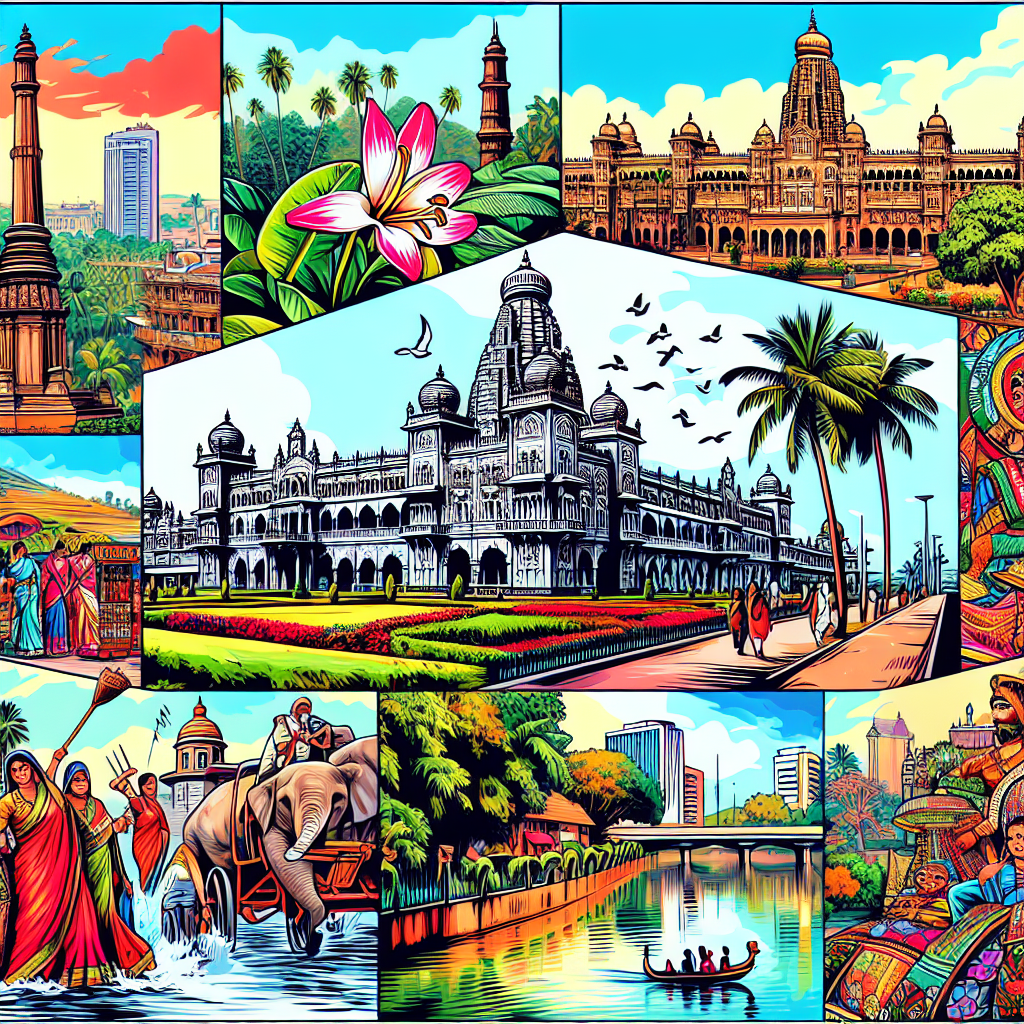

In [24]:
image = artist("Bangalore")
display(image)

In [25]:
def talker(message):
    response = openai_client.audio.speech.create(
        model = 'tts-1',
        voice = 'onyx', #alloy
        input = message
    )

    audio_stream = BytesIO(response.content)
    output_file = 'output_audio.mp3'
    with open(output_file, 'wb') as f:
        f.write(audio_stream.read())

    display(Audio(output_file,autoplay = True))

In [26]:
talker("Well, hi there")

In [33]:
def chat(history):
    messages = [{'role':'system','content':system_message}] + history
    response = openai_client.chat.completions.create(
        model = MODEL,
        messages = messages,
        tools = tools
    )
    image = None

    if response.choices[0].finish_reason == 'tool_calls':
        message = response.choices[0].message
        response,city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        image = artist(city)
        response = openai_client.chat.completions.create(model = MODEL, messages = messages)

    reply = response.choices[0].message.content
    history += [{'role':'assistant','content':reply}]

    talker(reply)

    return history,image

In [34]:
# More involved Gradio code as we're not using the preset Chat interface!
# Passing in inbrowser=True in the last line will cause a Gradio window to pop up immediately.

with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500)
    with gr.Row():
        entry = gr.Textbox(label="Chat with our AI Assistant:")
    with gr.Row():
        clear = gr.Button("Clear")

    def do_entry(message, history):
        history += [{"role":"user", "content":message}]
        return "", history

    entry.submit(do_entry, inputs=[entry, chatbot], outputs=[entry, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, image_output]
    )
    clear.click(lambda: None, inputs=None, outputs=chatbot, queue=False)

ui.launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7869

To create a public link, set `share=True` in `launch()`.


Tool get_ticket_price called for London
City name is london


Tool get_ticket_price called for Berlin
City name is berlin
